In [1]:
import argparse
from itertools import product as iterprod
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from argparse import ArgumentParser
import time
from datetime import datetime
from tqdm.autonotebook import tqdm
import pandas as pd

import matplotlib.pyplot as plt



/tmp/ipykernel_242015/3724148964.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import utils.data_2ch_processing as dp


from utils.UNeXt import UNet
from utils.loss_inference import loss_function_dict

import utils.nb_utils as nb_utils

import pprint

np.random.seed(11) # for reproducibility
torch.manual_seed(11)


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
batch_size = 8
num_workers = 4

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pin_memory = True if torch.cuda.is_available() else False

In [4]:
device


device(type='cuda', index=0)

# Build dataset

In [23]:
# Dataset
directory  = '/net/projects/CLS/force_reference/data/240423_fixed_EGFP_zyxin_pFAK/normed_data'

in_channels  = [[0]] 
out_channels = (1)
transform_kwargs = {'crop_size': 512,
                    'output_channels': out_channels                    
                    }

dataset_kwargs = { 
                    'root': directory,
                    'force_load': False,
                    'test_split': 'split_indices',                   
                    'in_channels': in_channels, 
                    'out_channels': out_channels, 
                    'transform_kwargs': transform_kwargs,
                    'frames_to_keep': 256,
                    'input_baseline_normalization': 'outside_inside', # Comment on what these do
                    'output_baseline_normalization': 'mean_dataset',
                    'remake_dataset_csv': True
                     }


dataset = dp.CellDataset( **dataset_kwargs )

train_loader = dataset.get_loader(dataset.train_indices, batch_size, num_workers, pin_memory)
validation_loader = dataset.get_loader(dataset.test_indices, batch_size, num_workers, pin_memory)

{'crop_size': 512, 'output_channels': 1}


In [24]:
dataset

# Some visualizations of the training data

The dataset class gets items by looking into a dataframe (`dataset.info`) where the folders and filenames are stored. Folders correspond to single cells, and each file is a frame of the time series. 

`dataset.info` contains the normalization values which the data is normalized by before it is passed to the NN. Forces are normalized by `dataset.info.F_mean` and the zyxin signal is normalized by `dataset.info.zyxin_baseline_out` and `dataset.info.zyxin_baseline_in`. Details about how these are generated can be found in the DataProcessing notebook.
    


In [25]:
df = dataset.info.copy()

df.head(10)

,folder,filename,frame,root
0,norm_Control_images,norm_Control_zxyin_pFAK_cell_000.tif.tif,0,/net/projects/CLS/force_reference/data/240423_...
1,norm_Control_images,norm_Control_zxyin_pFAK_cell_001.tif.tif,1,/net/projects/CLS/force_reference/data/240423_...
2,norm_Control_images,norm_Control_zxyin_pFAK_cell_002.tif.tif,2,/net/projects/CLS/force_reference/data/240423_...
3,norm_Control_images,norm_Control_zxyin_pFAK_cell_003.tif.tif,3,/net/projects/CLS/force_reference/data/240423_...
4,norm_Control_images,norm_Control_zxyin_pFAK_cell_004.tif.tif,4,/net/projects/CLS/force_reference/data/240423_...
5,norm_Control_images,norm_Control_zxyin_pFAK_cell_005.tif.tif,5,/net/projects/CLS/force_reference/data/240423_...
6,norm_Control_images,norm_Control_zxyin_pFAK_cell_006.tif.tif,6,/net/projects/CLS/force_reference/data/240423_...
7,norm_Control_images,norm_Control_zxyin_pFAK_cell_007.tif.tif,7,/net/projects/CLS/force_reference/data/240423_...
8,norm_Control_images,norm_Control_zxyin_pFAK_cell_008.tif.tif,8,/net/projects/CLS/force_reference/data/240423_...
9,norm_Control_images,norm_Control_zxyin_pFAK_cell_009.tif.tif,9,/net/projects/CLS/force_reference/data/240423_...


In [26]:
# Print test cells: 
print(dataset.test_cells)
print(dataset.test_indices)

{'split': 'none'}
[297  58 174  63 191 209 158 104 210  31 262  85 203  88 217 116  92 271
  24  83 159  86  69 266 164 212 227  89 194 176 216  10 260 295  51  32
  61   0 272  99 129 131  62   9 113 189 190 231  87 107  95]


In [27]:
dataset.info

,folder,filename,frame,root
0,norm_Control_images,norm_Control_zxyin_pFAK_cell_000.tif.tif,0,/net/projects/CLS/force_reference/data/240423_...
1,norm_Control_images,norm_Control_zxyin_pFAK_cell_001.tif.tif,1,/net/projects/CLS/force_reference/data/240423_...
2,norm_Control_images,norm_Control_zxyin_pFAK_cell_002.tif.tif,2,/net/projects/CLS/force_reference/data/240423_...
3,norm_Control_images,norm_Control_zxyin_pFAK_cell_003.tif.tif,3,/net/projects/CLS/force_reference/data/240423_...
4,norm_Control_images,norm_Control_zxyin_pFAK_cell_004.tif.tif,4,/net/projects/CLS/force_reference/data/240423_...
...,...,...,...,...
295,norm_Control_images,norm_Control_zxyin_pFAK_cell_295.tif.tif,295,/net/projects/CLS/force_reference/data/240423_...
296,norm_Control_images,norm_Control_zxyin_pFAK_cell_296.tif.tif,296,/net/projects/CLS/force_reference/data/240423_...
297,norm_Control_images,norm_Control_zxyin_pFAK_cell_297.tif.tif,297,/net/projects/CLS/force_reference/data/240423_...
298,norm_Control_images,norm_Control_zxyin_pFAK_cell_298.tif.tif,298,/net/projects/CLS/force_reference/data/240423_...


In [28]:

frame = 1

idx = dataset.info.index[(dataset.info.folder=='norm_Control_images')&(dataset.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.
print(idx)

1


In [29]:
dataset.out_channels


1

In [30]:
sample = dataset[idx]

{'mask': torch.Size([1, 1104, 1104]), 'zyxin': torch.Size([1, 1104, 1104]), 'pfak': torch.Size([1, 1104, 1104]), 'output': torch.Size([1, 1104, 1104])}


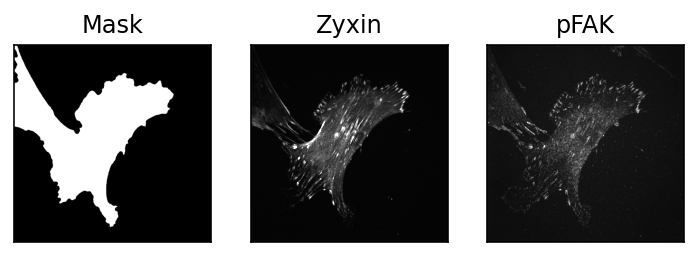

In [32]:
fig,ax=plt.subplots(1,3,figsize=(2*3, 4*2), dpi=144)


print({key: sample[key].shape for key in sample.keys()})

ax[0].set_title('Mask')
ax[0].imshow(sample['mask'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[1].set_title('Zyxin')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[2].set_title('pFAK')
ax[2].imshow(sample['output'][0,:,:].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

In [33]:
sample['output'][0,:,:].squeeze().max()

tensor(1.8676)

In [34]:
sample

{'mask': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]]]),
 'zyxin': tensor([[[0.0252, 0.0252, 0.0155,  ..., 0.0174, 0.0097, 0.0155],
          [0.0174, 0.0213, 0.0174,  ..., 0.0097, 0.0155, 0.0097],
          [0.0233, 0.0174, 0.0136,  ..., 0.0174, 0.0136, 0.0194],
          ...,
          [0.0271, 0.0426, 0.0368,  ..., 0.0097, 0.0213, 0.0271],
          [0.0388, 0.0213, 0.0271,  ..., 0.0136, 0.0116, 0.0174],
          [0.0329, 0.0271, 0.0446,  ..., 0.0174, 0.0233, 0.0136]]]),
 'pfak': tensor([[[0.0588, 0.0588, 0.0784,  ..., 0.0441, 0.0931, 0.0490],
          [0.0784, 0.0735, 0.0784,  ..., 0.0490, 0.0441, 0.0686],
          [0.0833, 0.0539, 0.0343,  ..., 0.0392, 0.0000, 0.0490],
          ...,
          [0.0490, 0.0539, 0.0686,  ..., 0.0882, 0.0833, 0.0343],
          [0

# Build U-Net model with ConvNext blocks

In [35]:
n_lyr  = 3 # number of downsampling layers
ds_krnl= 4 # downsample kernel
n_ch   = 4 # number of channels in the beginning of the network
n_blocks = 4 # number of ConvNext blocks, wherever ConvNext blocks are used

prepend_hparams = {'start_channel': 1, 'resnet_channel': n_ch, 'end_channel': n_ch, 'N_blocks': n_blocks,                                         # Args for architecture
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} # Args for ConvNext blocks
encoder_hparams = {'n_ch': n_ch, 'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'N_skip_blocks': n_blocks,
                    'downsample_kwargs': {'kernel': ds_krnl, 'activation': 'gelu', 'batchnorm': 1},
                    'interlayer_kwargs': {'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
                    }
decoder_hparams = {'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'upsample_kernel': ds_krnl,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
append_hparams = {'start_channel': n_ch, 'resnet_channel': n_ch, 'end_channel': 2, 'N_blocks': n_blocks,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 8, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} 
optimizer_hparams = {'LR': 0.001, 'schedule_rate': 0.99}
loss_hparams = {'loss_type': 'r_mse',
                'exp_weight': 0.0,
                'strainenergy_regularization': 0.0,
                'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'loss_kwargs': {'max_force': 8.}
               }





models = {}
for protein in ['zyxin1','zyxin2']:
    modelname = 'model_zyxin2pfak_50ep'

    logger_params = {'log_dir': f'./tensorboard_logs/{modelname}', 
                     'image_epoch_freq': 10,
                     'image_callbacks': 'vectorfield,hists',
                     'save_model_freq': 4}

    # Actually build model:
    model_kwargs={
                    'input_type':  protein[:-1], 
                    'prepend_hparams': prepend_hparams, 
                    'encoder_hparams': encoder_hparams, 
                    'decoder_hparams': decoder_hparams, 
                    'append_hparams': append_hparams, 
                    'optimizer_hparams': optimizer_hparams,
                    'loss_hparams': loss_hparams,
                    'logger_params': logger_params,
                    'name': 'model_0'}


    model = UNet( **model_kwargs, model_idx=0)
    model.to(device)
    
    models[protein] = model


In [36]:
models

{'zyxin1': UNet(
   (layers_encode): ModuleList(
     (0): ModuleList(
       (0-3): 4 x ConvNextCell(
         (conv0): Conv2d(4, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=4)
         (conv1): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
         (conv2): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
         (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act): GELU(approximate='none')
       )
       (4): DownsampleLayer(
         (conv): Conv2d(4, 8, kernel_size=(4, 4), stride=(4, 4))
         (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act): GELU(approximate='none')
       )
     )
     (1): ModuleList(
       (0-3): 4 x ConvNextCell(
         (conv0): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=8)
         (conv1): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         (conv2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
  

In [37]:
protein[:-1]

'zyxin'

# Perform training

In [39]:
save_models = True
n_epochs = 30

pbar = tqdm(total=n_epochs*(np.minimum(dataset.frames_to_keep, len(dataset.train_indices))/batch_size))

t0 = time.time()
for e in range(n_epochs):
    pbar.set_description(f'Epoch {e}')
    loss_values_train = {}
    loss_values_val = {}

    for mkey in models.keys():
        models[mkey].reset_running_train_loss()
        models[mkey].reset_running_val_loss()

    for sample in train_loader: 
        for key in sample:
            sample[key] = sample[key].to(device)
        
        for mkey in models.keys():
            models[mkey].training_step(sample, epoch=e) # loss.backward() and optimizer step occur in here
        
        pbar.update(1)

    for sample in validation_loader:
        for key in sample:
            sample[key] = sample[key].to(device)
    
        for mkey in models.keys():
            models[mkey].validation_step(sample, epoch=e)

    for mkey in models.keys():
        models[mkey].scheduler.step()

    print("Epoch %u:\t Time: %0.2f \t(per epoch: %0.2f)"%(e, time.time()-t0, (time.time()-t0)/(e+1)))
    print(loss_values_train)
    # SAVE
    if save_models:
        # Log in tensorboard
        # for mkey in models.keys():
        #     model[mkey].log_images(epoch=e)
        #     model[mkey].log_scalars(epoch=e) 
            
        # Save models
        if e%(logger_params['save_model_freq'])==0 or e==n_epochs-1: 
            torch.save({'model': model.state_dict(),
                        'model_kwargs': model_kwargs,
                        'model_name': model.name,
                        'model_idx': model.index,
                        'dataset_kwargs': dataset_kwargs,
                        'test_cells': dataset.test_cells,
                        }, 
                       os.path.join( model.logdir, 'model.pt') )


Epoch 0:   0%|          | 0/768.75 [02:37<?, ?it/s]
Epoch 0:   0%|          | 0/768.75 [00:00<?, ?it/s]

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 68 but got size 69 for tensor number 1 in the list.

In [20]:
loss_values_train

{}

# Plot prediction on train cell

In [ ]:
import tifffile
from utils.data67_processing import CellDataset, SubsetSampler

modelinfo = torch.load('/net/projects/CLS/force_reference/gitcodes/cell_force_prediction/tensorboard_logs/model_z2p_150ep_0/model.pt',  map_location=torch.device('cpu'))

dataset_kwargs = modelinfo['dataset_kwargs']
test_cells = dataset_kwargs['test_cells']

modelinfo['dataset_kwargs']['root'] = '/net/projects/CLS/force_reference/data/TractionData_27_04_21_ZyxinPaxillin/'
modelinfo['dataset_kwargs']['transform_kwargs']['crop_size'] = 960
modelinfo['dataset_kwargs']['transform_kwargs']['rotate'] = False

model = UNet(**modelinfo['model_kwargs'], model_idx = 0)

model.load_state_dict(modelinfo['model'])

dataset = CellDataset(**modelinfo['dataset_kwargs'])

sampler = SubsetSampler(np.arange(len(dataset)))
loader = torch.utils.data.DataLoader(dataset, 
    batch_size=1,
    shuffle=False,
    sampler=sampler,
    pin_memory=True)

for cell in ['cell_1','cell_2','cell_4','cell_5']:
    for frame in range(30):  

        idx = np.sort(dataset.info[dataset.info.folder==cell].index.values)
        idx = idx[frame]

        model.eval()
        model.to(torch.device('cuda:0'))

        sample = dataset[idx]
        for k in sample:
            sample[k] = sample[k].unsqueeze(0).to(torch.device('cuda:0'))

        preds = []
        for _ in range(5):
            pred = model(model.select_inputs(model.input_type, sample)).detach().cpu().numpy().squeeze()
            preds.append(pred)
            
        pred = np.mean(preds, axis=0) 
        target = sample['output'].detach().cpu().numpy().squeeze() 
        zyx = sample['zyxin'].detach().cpu().numpy().squeeze()
        pax = sample['actin'].detach().cpu().numpy().squeeze()


        fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

        ax[0].set_title('Zyxin')
        ax[0].imshow(zyx,  cmap='gray', vmax=zyx.max()/4, vmin=0)
        if cell == 'cell_1':
            ax[0].set_xlabel('Testing set: ' + cell)
        else:
            ax[0].set_xlabel('Training set: ' + cell)
            
            
        ax[1].set_title('Paxillin-Exp')
        ax[1].imshow(pax, cmap='gray', vmax=pax.max()/4, vmin=0)
        ax[1].set_xlabel('Frame '+ str(frame))
        
        ax[2].set_title('Paxillin-NN')
        ax[2].imshow(pred.squeeze()[0],  cmap='gray', vmax=pred.squeeze()[0].max()/4, vmin=0)


        tifffile.imsave(os.path.join('/net/projects/CLS/force_reference/zyxin2pax_prediction/tiff',cell + '_frame'+str(frame)+'.tif'),pred.squeeze()[0]/5)
        
        for a in ax.flat:
            a.set_xticks([])
            a.set_yticks([])
                    
        fig.savefig(os.path.join('/net/projects/CLS/force_reference/zyxin2pax_prediction/plot', cell + '_frame'+str(frame)+'.png'))
        plt.close(fig) 

# transform_kwargs = {'crop_size': 960,
#                     'output_channels': out_channels,
#                     'norm_output': {'rescale': 1, 'threshold': 0.4},
#                     'rotate': False
#                     }

# dataset_kwargs = { 
#                     'root': directory,
#                     'force_load': False,
#                     'test_split': 'bycell',
#                     'test_cells': test_cells,
#                     'in_channels': in_channels, 
#                     'out_channels': out_channels, 
#                     'transform_kwargs': transform_kwargs,
#                     'frames_to_keep': 256,
#                     'input_baseline_normalization': 'outside_inside', # Comment on what these do
#                     'output_baseline_normalization': 'mean_dataset',
#                     'remake_dataset_csv': True
#                      }

# model = models['zyxin1']

# eval_dataset_kwargs = dataset_kwargs
# eval_dataset_kwargs['exclude_frames'] = None
# dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

# for cell in ['cell_1','cell_2','cell_4','cell_5']:
#     for frame in range(30):   
       


#         # cell = 'cell_2'
#         # frame = 1

#         idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


#         sample = dataset_eval[idx] # get item

#         input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
#         # print(input_image.shape)

#         pred = model(input_image).detach().cpu().numpy()

#         # print(pred.shape)

#         # fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

#         # ax[0].set_title('Zyxin')
#         # ax[0].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=4, vmin=0)

#         # ax[1].set_title('Paxillin-Exp')
#         # ax[1].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=4, vmin=0)

#         # ax[2].set_title('Paxillin-NN')
#         # ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=4, vmin=0)

        
#         # tifffile.imsave(os.path.join('/net/projects/CLS/force_reference/zyxin2pax_prediction/tiff',cell + '_frame'+str(frame)+'.tif'),pred.squeeze()[0]/5)
        
#         # for a in ax.flat:
#         #     a.set_xticks([])
#         #     a.set_yticks([])
                    
#         # fig.savefig(os.path.join('/net/projects/CLS/force_reference/zyxin2pax_prediction/plot', cell + '_frame'+str(frame)+'.png'))
#         # plt.close(fig) 
        

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

model = models['zyxin2']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_1'
frame = 0


idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)


ax[0].set_title('Zyxin')
ax[0].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)

ax[1].set_title('Paxillin-Exp')
ax[1].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)

ax[2].set_title('Paxillin-NN')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=5, vmin=0)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

# Performance on test cell
## It seems to underpredict quite dramatically, but we don't necessarily expect great generalization because the network was trained on an extremely small dataset (~180 frames).

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(3*3, 3*1), dpi=200)

model = models['actin1']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_1'
frame = 100

idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)

ax[0].set_title('Paxillin')
ax[0].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)

ax[1].set_title('Zyxin-Exp')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=300, vmin=0)

ax[2].set_title('Zyxin-NN')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=1000, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])